In [46]:
from matplotlib.pyplot import *
import numpy as np
import h5py
from Data_Core.experiment import *
from Data_Core.digital_twin import *
from tqdm import tqdm
#from src.algorithms import *
#import torch
import sklearn
import PIL
from PIL import Image
import cv2
%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
find_index = lambda wavelenghts, w : np.argmin(np.abs(wavelenghts - w))

In [3]:
def Raman_data_loader(filename):

    with h5py.File(filename, 'a') as output_file:
         
        properties = output_file['properties']
        
        exp_properties = {'step_size' : np.array(properties['step_size'])[0],
                          'speed' : np.array(properties['speed']),
                          'n_points' : np.array(properties['n_points'])
            }
        
        wavelengths = np.array(output_file['properties']['x_data'])
        
        
        spot_numbers = [int(s.split('_')[-1]) for s in list(output_file['data'].keys()) if 'spot' in s ]
        
        Nx,Ny = output_file['properties']['n_points'][0], output_file['properties']['n_points'][1]
        Nl = len(wavelengths)
        spectral_signal = np.zeros([Nx,Ny,Nl])
        
        
        for _i, spot_number in enumerate(spot_numbers):

            ix, iy = int(spot_number//Ny), int(spot_number%Ny)
            
            spot = 'spot_'+str(spot_number)
            data = np.array(output_file['data'][spot]['raw_data'])
                      
            spectral_signal[ix,iy,:] = data
            

    return spectral_signal, wavelengths, exp_properties

In [4]:
#filename = "2023913_1110.h5" #original
#filename = "202310 9_1132.h5" #pedras mais pequenas
#filename='202310 9_1420.h5'
filename1='20231130_ 858.h5' #pedra potencia 30%
filename2='20231129_15 9.h5' #pedra potencia 40%
filename3='20231130_1053.h5' #pedra potencia 60%
spectrum_raman_1, wavelengths_raman, exp_properties = Raman_data_loader(filename1) #P=30%
spectrum_raman_2, wavelengths_raman, exp_properties = Raman_data_loader(filename2)# P=40%
spectrum_raman_3, wavelengths_raman, exp_properties = Raman_data_loader(filename3)#P=60%

In [5]:
exp_properties

{'step_size': 0.5,
 'speed': array([b'5.000', b'5.000'], dtype=object),
 'n_points': array([100,  50])}

In [6]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als_optimized(y, lam, p, niter = 10):
    L = len(y)
    D = sparse.diags([1, -2, 1],[0, -1, -2], shape = (L, L - 2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

In [7]:
spectra=np.array([spectrum_raman_1,spectrum_raman_2,spectrum_raman_3])


In [178]:
E=np.array([150,200,300])
logE=np.log(E)
p1=[]
p2=[]
for image in range (len(spectra)):
        p1.append(np.sum(spectra[image][:,:,100]))
        p2.append(logE[image])
        

In [182]:
len(p2)

3

<IPython.core.display.Javascript object>


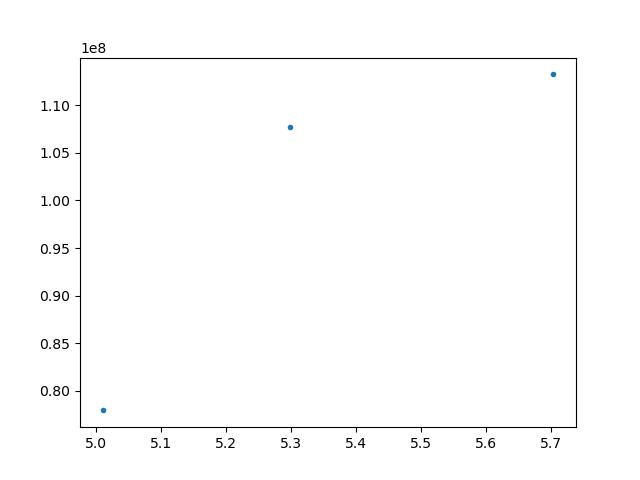

In [186]:
subplots()
plt.plot(p2,p1,'.')
plt.show()

In [181]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def exp_f(x, a, b,c):
    return a * np.exp(x+c)+b
p1=np.array(p1)
p2=np.array(p2)

# Plotting the original data
plt.plot(p2, p1, '.')

# Fitting the exponential function to the data
p, cov = curve_fit(exp_f, p2, p1)

# Plotting the fitted curve
p2_n=np.linspace(p2[0],p2[-1],100)
plt.plot(p2_n, exp_f(p2_n, p[0], p[1],p[2]), '-')

plt.show()
print(p)

[1.46837307e+01 5.42387588e+07 9.56557015e+00]


C:\Users\zecar\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [8]:
lam = 1e2
p = 1e-1
pro_data_geral=[]
for spect in spectra:
    spectrum_raman=spect
    pro_data = 1*spectrum_raman
    for i in tqdm(range(0, pro_data.shape[0])):
        for j in range(0, pro_data.shape[1]):
            # print(i,j,end='\r')
            spec = 1 * pro_data[i, j, :]
            pro_data[i, j, :] = spec - baseline_als_optimized(spec, lam = lam, p = p, niter = 10)
    pro_data_geral.append(pro_data)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:05<00:00,  1.85s/it]


In [9]:
pro_data_geral=np.array(pro_data_geral)
pro_data_geral.shape

(3, 100, 50, 1024)

In [10]:
pro_data_norm_geral=pro_data_geral.copy()


for spect in range(3):
    for i in range(0,pro_data.shape[0]):
        for j in range(0,pro_data.shape[1]):
            spec = 1 * pro_data_geral[spect,i,j, :]
            sum_spec=np.sum(spec)
            if sum_spec==0:
                pro_data_norm_geral[spect,i,j,:]=0
            else:
                pro_data_norm_geral[spect,i,j,:]=spec/sum_spec

In [11]:
offset_l = 31
offset_m = 328

mask1 = pro_data_norm_geral[0,:, :, offset_l:offset_m]
mask2 = pro_data_norm_geral[1,:, :, offset_l:offset_m]#.reshape(pro_data.shape[0]*pro_data.shape[1], -1)
mask3 = pro_data_norm_geral[2,:, :, offset_l:offset_m]


In [12]:
mask1.shape

(100, 50, 297)

In [13]:
mask_geral=np.array([mask1,mask2,mask3])
mask_geral.shape

(3, 100, 50, 297)

## HDR - chat gpt

import numpy as np
import matplotlib.pyplot as plt
 
def load_images(file_paths):
    images = [plt.imread(file_path) for file_path in file_paths]
    return images
 
def compute_weights(images):
    weights = [np.max(img, axis=2) for img in images]
    return weights
 
def compute_radiance(images, weights):
    num_images = len(images)
    num_pixels = images[0].shape[0] * images[0].shape[1]
 
    # Stack all images into a 2D array (pixels x channels)
    stacked_images = np.vstack([img.reshape(num_pixels, -1) for img in images])
 
    # Stack all weights into a 1D array
    stacked_weights = np.hstack(weights)
 
    # Create a sparse matrix to store A matrix (pixels x images)
    A_sparse = np.zeros((num_pixels * num_images, num_images))
 
    # Fill the sparse matrix with weights
    for i in range(num_images):
        A_sparse[i * num_pixels : (i + 1) * num_pixels, i] = stacked_weights[i]
 
    # Solve for radiance values using the least squares method
    radiance = np.linalg.lstsq(A_sparse, stacked_images.flatten(), rcond=None)[0]
 
    # Reshape the radiance values back to the image shape
    radiance = radiance.reshape((num_pixels, -1))
 
    return radiance
 
def tonemap(radiance):
    # Simple tonemapping (linear scaling)
    tonemapped = np.clip(radiance, 0, 1)
    return tonemapped
 
def main():
    # Replace these paths with your own image paths
    image_paths = ["image1.jpg", "image2.jpg", "image3.jpg"]
 
    # Load images
    images = load_images(image_paths)
 
    # Compute weights
    weights = compute_weights(images)
 
    # Compute radiance map
    radiance = compute_radiance(images, weights)
 
    # Tonemap the radiance map
    tonemapped = tonemap(radiance)
 
    # Display the result
    plt.imshow(tonemapped)
    plt.axis("off")
    plt.show()
 



            

In [14]:
def compute_weights(images):
    weights = [np.max(img, axis=2) for img in images]
    return np.array(weights)
we=compute_weights(mask_geral)

In [15]:
np.array(we).shape

(3, 100, 50)

In [35]:
def compute_radiance(images, weights):
    num_images = len(images)
    num_pixels = images[0].shape[0] * images[0].shape[1]
    print('n pixels',num_pixels)
    print('n images',num_images)
    # Stack all images into a 2D array (pixels x channels)
    stacked_images = np.vstack([img.reshape(num_pixels, -1) for img in images])
    print('shape stacked images',stacked_images.shape)

    # Stack all weights into a 1D array
    stacked_weights_vec=[]
    for i in range(3):
        stacked_weights_0 = np.hstack(weights[i,:,:])
        stacked_weights_vec.append(stacked_weights_0)
    
        
    stacked_weights=np.hstack(stacked_weights_vec)
    print('stacked weights shape', stacked_weights.shape)
 
    # Create a sparse matrix to store A matrix (pixels x images)
    A_sparse = np.zeros((num_pixels * num_images, num_images))
 
    # Fill the sparse matrix with weights
    for i in range(num_images):
        A_sparse[i * num_pixels : (i + 1) * num_pixels, i] = stacked_weights[i]
 
  
    print('sparse matrix',A_sparse.shape)
    print('shape flat stacked_images',stacked_images.flatten().shape)
    
    #Solve for radiance values using the least squares method
    radiance = np.linalg.lstsq(stacked_images,A_sparse, rcond=None)[0]
 
    return radiance

In [36]:
radiance=compute_radiance(mask_geral,we)
radiance.shape


n pixels 5000
n images 3
shape stacked images (15000, 297)
stacked weights shape (15000,)
sparse matrix (15000, 3)
shape flat stacked_images (4455000,)


(297, 3)

In [101]:
mask_geral.shape

(3, 100, 50, 297)

In [118]:
saturation_matrix=np.zeros([mask_geral.shape[1],mask_geral.shape[2]])
img=mask_geral[1]
sat=[]
for i in range(100):
    for j in range(50):
        soma=np.sum(img[i,j,:])
        sat.append(1-297/soma*np.min(img[i][j][:]))
        

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 7.000e+00, 1.150e+02, 2.040e+02,
        1.630e+02, 1.500e+01, 1.400e+01, 2.400e+01, 2.000e+01, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.234e+03, 3.164e+03, 5.000e+00, 1.500e+01, 4.000e+00, 3.000e+00,
        4.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

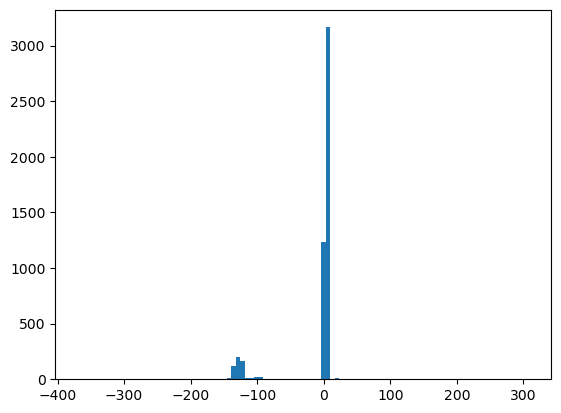

In [125]:
plt.hist(sat,bins=100)

In [167]:
sat=np.array(sat).reshape(100,50)
merged_mask=np.zeros([100,50,297])
for i in range(100):
    for j in range(50):
        if sat[i,j]<-20:
            merged_mask[i,j,:]=mask3[i,j,:]
        elif sat[i,j]>20:
            merged_mask[i,j,:]=mask1[i,j,:]
        else:
            merged_mask[i,j,:]=mask2[i,j,:]

In [168]:
merged_mask=merged_mask.reshape(5000,297)

In [169]:
threshold = 0.0007
mask=merged_mask
mask_offset = mask
mask_t = np.array([(mask_offset[:, i])*((mask_offset[:, i] > threshold)) for i in range(mask_offset.shape[-1])])



In [170]:
init_k=([0],[1])

In [171]:

mask_min_max = np.array([(mask_t[i, :] - mask_t[i, :].min(axis = 0)+ 1e-5)/(mask_t[i, :].max(axis = 0) - mask_t[i, :].min(axis = 0) + 1e-5) for i in range(mask_t.shape[0])])
masks = np.array([sklearn.cluster.KMeans(n_clusters = 2, init = init_k, random_state = 100).fit_predict(mask_min_max[i, :].reshape(-1, 1)) for i in range(mask_min_max.shape[0])])



C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

In [172]:
def read_ref(mineral):
    df = pd.read_csv(mineral + '_raman.txt',header=13,names=['wavenumber','int'],skipfooter=4,engine='python' )
    return np.array(df['wavenumber']),np.array(df['int'])

<IPython.core.display.Javascript object>


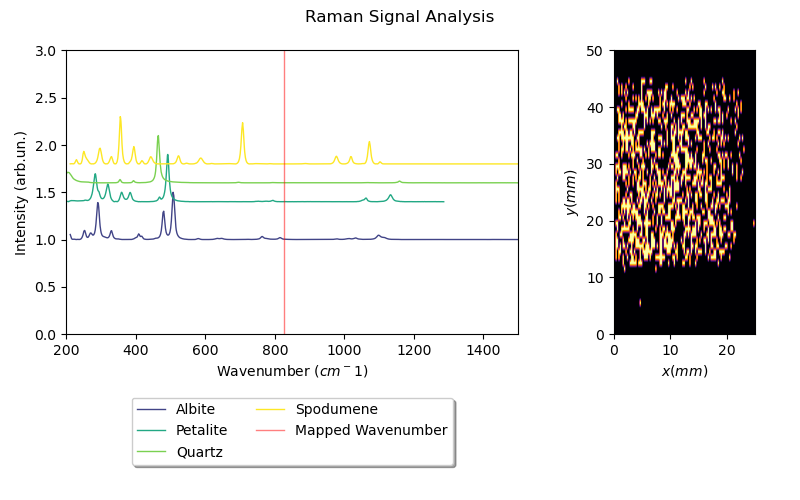

Albite
Background
Background not found
Petalite
Quartz
Spodumene


In [173]:
%matplotlib notebook
fig, ax = subplots(1, 2, figsize = (8, 5), gridspec_kw = {'width_ratios': [0.9, 0.4]})
fig.suptitle('Raman Signal Analysis')

axs = ax[0]
minerals = {
    
    'Albite':[508.1],
    'Background':[733.1],
    'Petalite':[491.3],
    'Quartz':[463.92],
    'Spodumene':[704.5]}

mineral_list = list(minerals.keys())
for i,mineral in enumerate(mineral_list):
    print(mineral)
    try:
        wl,spec = read_ref(mineral)
        axs.plot(wl, 1 + 0.2*i + 0.5 * spec/np.max(spec), lw = 1, color = cm.viridis((i+1)/len(mineral_list)), label = mineral)
    except:
        print(mineral + ' not found')
axs.set_ylim(0,1+0.2*(i+1)+1)
axs.set_xlim(200,1500)
    
axs.legend(loc = 'upper right', bbox_to_anchor = (1.0, 1.0), ncol = 2, fancybox = True, shadow = True)
wn = 120
line = axs.axvline(wavelengths_raman[offset_l:offset_m][wn], lw = '1', alpha = 0.5, color = 'red', label = 'Mapped Wavenumber')
axs.set_xlabel(r'Wavenumber $(cm^-1)$')
axs.set_ylabel(r'Intensity (arb.un.)')
axs.legend(loc='upper center', bbox_to_anchor = (0.5, -0.2), ncol = 2, fancybox = True, shadow = True)

axs = ax[1]
axs.imshow(masks.T.reshape(pro_data.shape[0], pro_data.shape[1], -1)[:, :, wn].T, cmap = cm.inferno, extent = [0, exp_properties['step_size']*exp_properties['n_points'][1],
                                                        0, exp_properties['step_size']*exp_properties['n_points'][0]])
axs.set_xlabel(r'$x(mm)$')
axs.set_ylabel(r'$y(mm)$')


def update_map(wn):
    im = ax[1].imshow(masks.T.reshape(pro_data.shape[0], pro_data.shape[1], -1)[:, :, wn].T, cmap = cm.inferno,
                      extent = [0, exp_properties['step_size']*exp_properties['n_points'][1],
                            0, exp_properties['step_size']*exp_properties['n_points'][0]],
                     interpolation = 'none')
    line.set_xdata(wavelengths_raman[offset_l:offset_m][wn])

def onclick(event):
    ix, iy = event.xdata, event.ydata
    wn = find_index(wavelengths_raman[offset_l:offset_m], ix)
    if event.inaxes == ax[0] or ax0:
        update_map(wn)
        fig.canvas.draw_idle()
        
cid = fig.canvas.mpl_connect('button_press_event', onclick)
fig.tight_layout()

In [174]:

kmeans = sklearn.cluster.KMeans(n_clusters = 5)
a=kmeans.fit_predict(masks)

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [175]:
# labels = kmeans.labels_.cpu()
labels = kmeans.labels_

<IPython.core.display.Javascript object>


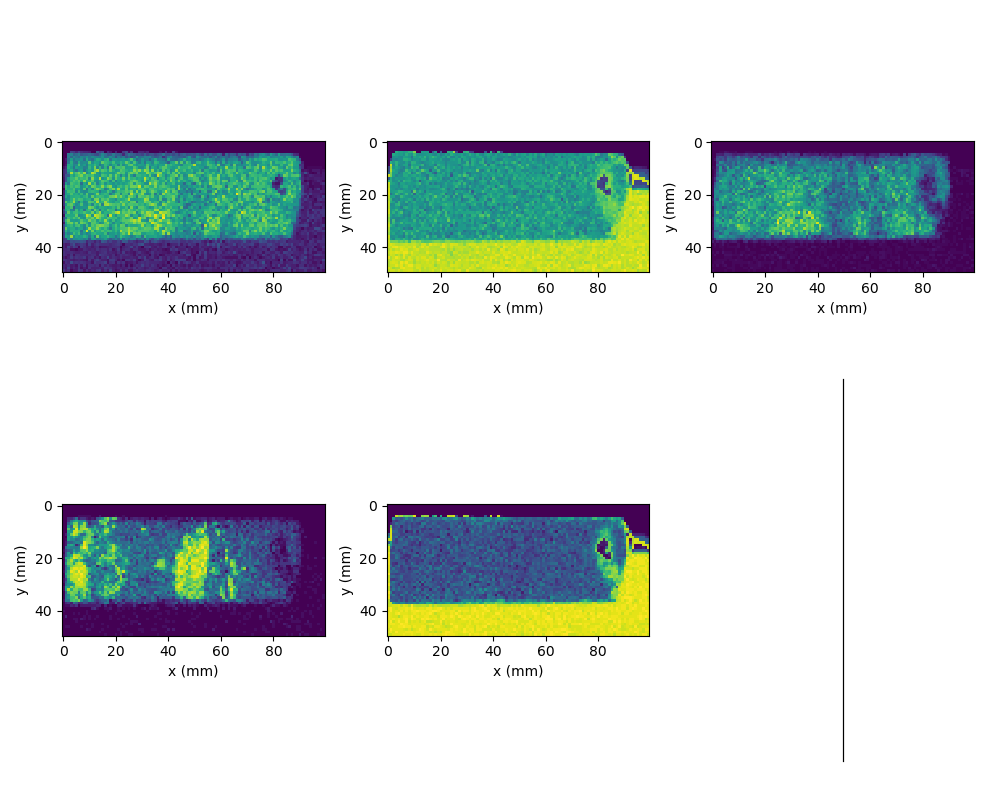

In [176]:
fig, ax = subplots(2, 3, figsize = (10, 8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

image=Image.open('segunda_pedra - Cópia.JPG')

ax[-1,-1].imshow(image)
ax[-1,-1].set_xticks([])
ax[-1,-1].set_yticks([])
savefig('segundapedra_hdr_porsat.JPG',dpi=500)